Lets create a Neural Network to implement Logistic Regression from scratch

Importing libraries:

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import sklearn as sk
import sklearn.datasets 
import sklearn.linear_model 
import matplotlib 
 
# Display plots inline and change default figure size 
%matplotlib inline 

We use make_circles dataset generated by sklearn library for our classification purpose:

This generates a dataset with two-class target variable and two predictors. The target variable has classes 1 and 0 represented by colors 'red' and 'blue' in the scatterplot.

In [2]:
np.random.seed(1431)

X, Y = sk.datasets.make_circles(n_samples = 400, noise = 0.2)

Scatter Plot:

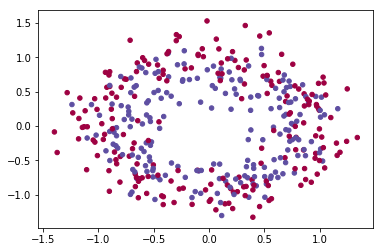

In [3]:
plt.scatter(X[:,0], X[:,1], s=20, c=Y, cmap=plt.cm.Spectral)

In [4]:
# Helper function to plot decision boundary:

def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Spectral)

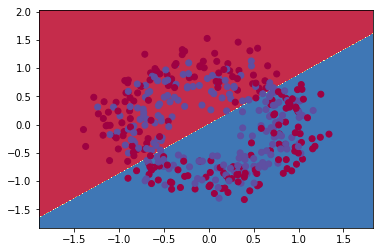

In [5]:
# Logistic Regression Using Sklearn:

model = sk.linear_model.LogisticRegressionCV()
model.fit(X, Y)

# Decision Boundary:

plot_decision_boundary(lambda x: model.predict(x))

In [6]:
Y = np.reshape(Y, (400, 1))

Building Neural Network: Lets buil our neural network using code blocks each of which implements a specific task.

### Network Structure:

Lets define the network's structure based on the number of inputs and size of the hidden layer

In [7]:
def layer_sizes(x, y, hidden = 3):
    n_x = x.shape[0]
    n_h = hidden
    n_y = y.shape[0]
    return (n_x, n_h, n_y)

layer_sizes(X, Y, hidden = 2)

(400, 2, 400)

### Random Initialization of Weights:

We are to caliculate the set of weights that would result in the least value of our cost function. For that purpose lets initialize the weights matrices using np.random.randn function.

In [8]:
def initialize_weights(n_x, n_h, n_y):
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    weights = {'W1': W1,
               'b1': b1,
               'W2': W2,
               'b2': b2 }
    
    return weights

n_x, n_h, n_y = layer_sizes(X, Y, 4)

print(initialize_weights(n_x, n_h, n_y)['W1'].shape,
      initialize_weights(n_x, n_h, n_y)['b1'].shape,
      initialize_weights(n_x, n_h, n_y)['W2'].shape,
      initialize_weights(n_x, n_h, n_y)['b2'].shape)

(4, 400) (4, 1) (400, 4) (400, 1)


### Forward Propagation:

Let's build a function to create weights for each layer based on the inputs from previous layers. But before that we need to define the activation function for the final layer. Since, we are dealing with a two-level classification problem, we can use the sigmoid function as our final activation funciton.

In [9]:
def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

In [28]:
def forward_prop(X, weights):
    
    W1 = weights['W1']
    b1 = weights['b1']
    W2 = weights['W2']
    b2 = weights['b2']
    
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    cache = {'Z1': Z1,
             'A1': A1,
             'Z2': Z2,
             'A2': A2}
    
    return A2, cache
    
weights = initialize_weights(400, 4, 400)
A2, cache = forward_prop(X, weights)
cache['Z2'].shape

(400, 2)

### Cost Function:

Here we use the following implementation of cross-entropy loss:
        C = $- \sum\limits_{i=0}^{m} y^{(i)}\log(a^{[2](i)}) + (1 - y^{(i)})\log(1-a^{[2](i)})$.
        
So, let's define a function to evaluate the cost in above mentioned method.

In [11]:
def cost_cal(A2, Y, weights):
    
    m = Y.shape[1]
    logprob = np.multiply(Y, np.log(A2)) + np.multiply((1-Y), np.log(1-A2))
    cost = -np.sum(logprob)/m
    
    cost = np.squeeze(cost)
    
    return cost

cost_cal(A2, Y, weights)

554.5032902313019

### Back Propagation:

The final step before we move on to the gradient descent algorithm is to calculate backward propagation, i.e., the partial derivatives of cost function with respect to weights and outputs from each layer.

In [12]:
def back_prop(weights, cache, X, Y):
    
    m = X.shape[1]
    
    W1 = weights['W1']
    W2 = weights['W2']
    
    A1 = cache['A1']
    A2 = cache['A2']
    
    # Derivatives
    
    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis = 1, keepdims = True)
    dZ1 = np.dot(W2.T, dZ2) * (1 - (A1 ** 2))
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis = 1, keepdims = True)
    
    gradients = {'dW1': dW1,
                 'db1': db1,
                 'dW2': dW2,
                 'db2': db2}
    
    return gradients

grads = back_prop(weights, cache, X, Y)

grads['dW1'].shape

(4, 400)

### Parameter updation using gradients:

Now lets write a function to update parameters based on gradients calculated in each iteration:

In [13]:
def weight_update(weights, gradients, learning_rate = 1.2):
    
    W1 = weights['W1']
    b1 = weights['b1']
    W2 = weights['W2']
    b2 = weights['b2']
    
    dW1 = gradients['dW1']
    db1 = gradients['db1']
    dW2 = gradients['dW2']
    db2 = gradients['db2']
    
    W1 = W1 - (learning_rate * dW1)
    b1 = b1 - (learning_rate * db1)
    W2 = W2 - (learning_rate * dW2)
    b2 = b2 - (learning_rate * db2)
    
    weights = {'W1': W1,
               'b1': b1,
               'W2': W2,
               'b2': b2}
    
    return weights

weights = weight_update(weights, grads, 1.2)
weights['W1'].shape

(4, 400)

### Neural Network implementation:

We finally have all the tools required to run our neural network model, lets define a neural network function which uses gradient descent algorithm using those tools

In [34]:
def model(X, Y, n_h, iterations = 10000, learning_rate = 1.2):
    
    np.random.seed(1431)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    weights = initialize_weights(n_x, n_h, n_y)
    
    W1 = weights['W1']
    b1 = weights['b1']
    W2 = weights['W2']
    b2 = weights['b2']
    
    
    for i in range(0, iterations):
        
        A2, cache = forward_prop(X, weights)
        
        cost = cost_cal(A2, Y, weights)
        
        grads = back_prop(weights, cache, X, Y)
        
        weights = weight_update(weights, grads, learning_rate)
        
        # to print cost every 1000 iterations:
        if i % 1000 == 0:
            print('Cost after %i iterations: %f' %(i, cost))
            
            
    return weights

### Model Predictions:

Finally, we have our neural network model. Let's use our model to make predicitons and compare that to the results of our previous model - logistic regression

In [30]:
def predict(X, weights):
    
    A2, cache = forward_prop(X, weights)
    predictions = (A2 > 0.5).astype(int)
    
    return predictions

In [33]:
# Build a model with a n_h-dimensional hidden layer
weights = model(X, Y, 4, 11000, 2)
predictions = predict(X, weights)

Cost after 0 iterations: 554.538874
Cost after 1000 iterations: 0.079820
Cost after 2000 iterations: 0.039949
Cost after 3000 iterations: 0.026643
Cost after 4000 iterations: 0.019986
Cost after 5000 iterations: 0.015991
Cost after 6000 iterations: 0.013327
Cost after 7000 iterations: 0.011424
Cost after 8000 iterations: 0.009996
Cost after 9000 iterations: 0.008886
Cost after 10000 iterations: 0.007997


### Accuracy:

In [17]:
predictions = predict(X, weights)
#print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

ValueError: shapes (400,1) and (2,400) not aligned: 1 (dim 1) != 2 (dim 0)